In [2]:
import os
import csv
import pandas as pd
import numpy as np

import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import squarify

from sklearn import model_selection, preprocessing, metrics
plt.style.use('fivethirtyeight')

print(os.getcwd())
print(os.listdir("../"))

/Users/divyam/Dev/Data_Science/DSF_Project/AcademicPaperRanking
['AcademicPaperRanking', 'mag_2007.csv', 'mag_2013.csv', 'mag_2012.csv', 'mag_2010.csv', 'mag_2011.csv', '.DS_Store', 'mag_2015.csv', 'mag_2014.csv', 'mag_2016.csv', 'dblp.csv', 'mag_2017.csv', 'sys_argv.py', 'common_progress_kernel.ipynb', 'mag_2018_processed.csv', 'acm.csv', 'dblp.txt', 'aminer_papers_0.zip', 'mag_2018.csv', 'acm.txt', 'acm_data_processing.py', 'mag_2008.csv', 'mag_2009.csv']


In [ ]:
def clean_data(df):
    #since first column contains row number
#     df.drop(["Row_num"], axis=1)
    #removing  and kesEntityId as simillar fields are already present
    df = df.drop(columns=["Row_num","kesEntityId"],axis=1)
    df["Popularity"] = df["Popularity"].apply(pd.to_numeric,downcast='float')
    df["Year"] = df["Year"].apply(pd.to_numeric,downcast='unsigned')
    df["Month"] = df["Month"].apply(pd.to_numeric,downcast='unsigned')
    df = df.dropna(subset=['Venue'])
    return df

In [3]:
# df_pub = pd.read_csv("../input/scopus-data/ProcessedScopusData.csv")
# If this doesn't work, please change it to the path where the file is locaed in your PC
df_pub = pd.read_csv("Data/ProcessedScopusData.csv")

In [4]:
df_pub.head(5)

,Unnamed: 0,Scopus SourceID,Title,CiteScore,Percentile,Citation Count,Scholarly Output,Percent Cited,SNIP,SJR,...,Type,OpenAccess,Scopus ASJC Code (Sub-subject Area),Scopus Sub-Subject Area,Quartile,Top 10% (CiteScore Percentile),Scopus SourceID.1,Print-ISSN,E-ISSN,Subject Area
0,0,28773.0,Ca-A Cancer Journal for Clinicians,130.47,99.0,16961.0,130.0,70.0,88.164,61.786,...,Journal,NO,2720.0,Hematology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/28773,00079235,15424863,Medicine
1,1,28773.0,Ca-A Cancer Journal for Clinicians,130.47,99.0,16961.0,130.0,70.0,88.164,61.786,...,Journal,NO,2730.0,Oncology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/28773,00079235,15424863,Medicine
2,2,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,2713.0,Epidemiology,Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Medicine
3,3,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,3306.0,Health(social science),Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Social Sciences
4,4,19434.0,MMWR. Recommendations and reports : Morbidity ...,63.12,99.0,1010.0,16.0,100.0,32.534,34.638,...,Journal,YES,2307.0,"Health, Toxicology and Mutagenesis",Quartile 1,Top 10%,https://www.scopus.com/sourceid/19434,10575987,15458601,Environmental Science


In [5]:
df_pub.isna().sum()

Unnamed: 0                             0
Scopus SourceID                        0
Title                                  0
CiteScore                              0
Percentile                             0
Citation Count                         0
Scholarly Output                       0
Percent Cited                          0
SNIP                                   0
SJR                                    0
RANK                                   0
Rank Out Of                            0
Publisher                              0
Type                                   0
OpenAccess                             0
Scopus ASJC Code (Sub-subject Area)    0
Scopus Sub-Subject Area                0
Quartile                               0
Top 10% (CiteScore Percentile)         0
Scopus SourceID.1                      0
Print-ISSN                             0
E-ISSN                                 0
Subject Area                           0
dtype: int64

In [ ]:
def append_pub_score(df):
    print("Unique Publications from Scopus:",len(df_pub.Title.unique()))
    # Analysing Common Publications
    vfn_list = df.Venue.unique().tolist()
    scopus_list = df_pub.Title.unique().tolist()
    count = 0
    for pub in scopus_list:
        if pub in vfn_list:
            count +=1
    print("Publications present in Dataset:",count)
    print("Shape Before",df.shape)
    df = df[df.Venue.isin(scopus_list)]
    print("Shape After",df.shape)
    #score appending
    score_dict = pd.Series(df_pub.SJR.values,index=df_pub.Title).to_dict()
    df["Publication_Rank"] = df.apply(lambda row: score_dict[row["Venue"]],axis = 1)
    return df

def extract_field(row):
    val = row["Domain"]
    index = val.rfind("FN")
    val = val[index+3:len(val)]
    val = val.strip(":}] '")
    return val

def get_num_authors(row):
    vals = row["Authors"].split("},")
    return len(vals)

In [ ]:
label_dict = {"C":0,"J":1,"CJ":2,"O":3}
def find_conference_type(row):
    if pd.isnull(row["Conference"]) and pd.isnull(row["Journal"]):
        return label_dict["O"]
    elif pd.isnull(row["Conference"]):
        return label_dict["J"]
    elif pd.isnull(row["Journal"]):
        return label_dict["C"]
    else:
        return label_dict["CJ"]

In [ ]:
def tidy_split(df, column, sep='|', keep=False):
    indexes = list()
    id_values = list()
    name_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            id_values.append(presplit)
        for value in values:
            indexes.append(i)
            val = value
            index1 = val.find("AuId")
            index2 = val.find("AfN")
            index3 = val.find("'S'")
            if index3 < index1:
                val = val[index1+4:index2]
                val = val.strip("', :")
            else:
                val = val[index1+4:index3]
                val = val.strip("', :")                
            id_values.append(val)
            index1 = value.find("AuN")
            val = value[index1+3:]
            val = val.strip("': }]")
            name_values.append(val)
    new_df = df.iloc[indexes, :].copy()
    new_df[column+"_Id"] = id_values
    new_new_df = new_df.iloc[:, :].copy()
    new_new_df[column+"_Name"] = name_values
    return new_new_df

In [ ]:
def process_year(df):
    # Make more sensible column names
    rename_dict = {"AA": "Authors", 
                   "C": "Conference", 
                   "CC": "Citation_count",
                   "ECC": "Expected_count",
                   "D": "Date", 
                   "F": "Domain", 
                   "J": "Journal", 
                   "RId": "References", 
                   "Ti": "Title", 
                   "VFN": "Venue", 
                   "W": "Words", 
                   "Y": "Year", 
                   "logprob":"Popularity",
                   "Unnamed: 0": "Row_num"}
    df.rename(index=str, columns=rename_dict, inplace=True)
    df.drop_duplicates(subset=['Title'], inplace=True)
    df["Month"] = pd.to_datetime(df["Date"]).dt.month
    df = clean_data(df)
    df = append_pub_score(df)
    df["Publication Type"] = df.apply(lambda row:find_conference_type(row),axis=1)
    df["Number_Of_authors"] = df.apply(lambda row:get_num_authors(row), axis = 1)
    return df

In [ ]:
# df = pd.read_csv("../input/mag-2007/mag_2007.csv")

In [ ]:
# df = process_year(df)

In [ ]:
# df.to_csv("mag_2007_processed.csv")

In [22]:
print(os.listdir("../processedmagdata"))

['mag_2016_processed.csv', 'mag_2012_processed.csv', 'mag_2015_processed.csv', 'mag_2011_processed.csv', 'mag_2008_processed.csv', 'mag_2018_processed.csv', 'mag_2009_processed.csv', 'mag_2007_processed.csv', 'mag_2010_processed.csv', 'mag_2014_processed.csv', 'mag_2013_processed.csv', 'mag_2017_processed.csv']


In [177]:
# to load just 1 year
df = pd.read_csv("../processedmagdata/mag_2017_processed.csv")

In [23]:
columns = ['Unnamed: 0','Authors', 'Conference','Citation_count','Date','Expected_count','Domain','Id','Journal','References','Title','Venue','Words','Year','Popularity','Month','Publication_Rank','Publication Type','Number_Of_authors']

In [ ]:
df = pd.DataFrame(columns = columns)
# please give a path that works on your machine. Keep all the processed files in this path
path = "../processedmagdata/"
for file in os.listdir(path):
#     print(file)
    df_temp = pd.read_csv(path+"/"+file)
    df = df.append(df_temp)

In [39]:
df.isna().sum()

Unnamed: 0                0
Authors                   0
Conference           129899
Citation_count            0
Date                      0
Expected_count            0
Domain                  243
Id                        0
Journal                 757
References            20631
Title                     0
Venue                     0
Words                     2
Year                      0
Popularity                0
Month                     0
Publication_Rank          0
Publication Type          0
Number_Of_authors         0
dtype: int64

In [40]:
# No duplicate values :)
df[df.duplicated()]

,Unnamed: 0,Authors,Conference,Citation_count,Date,Expected_count,Domain,Id,Journal,References,Title,Venue,Words,Year,Popularity,Month,Publication_Rank,Publication Type,Number_Of_authors


In [41]:
#size of data
df.shape

(130204, 19)

In [42]:
df["Publication Type"].value_counts()

1    129447
3       452
0       305
Name: Publication Type, dtype: int64

Should we remove rows with 0 references and 0 Citation count

In [140]:
# Number of rows with 0 citation count and 0 References
df[ (df['References'].isnull()) & (df['Citation_count']==0)].shape[0]

12572

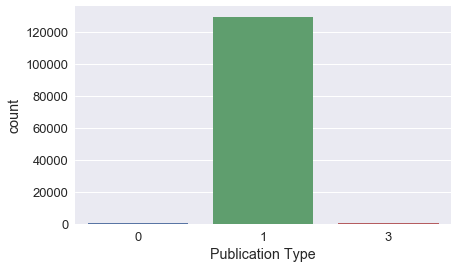

In [99]:
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Publication Type", data=df)

In [ ]:
# import seaborn as sns
# sns.set(style="darkgrid")
# ax = sns.countplot(x="Venue", data=df)

Text(0.5,0.98,'Distribution of Paper published in Years')

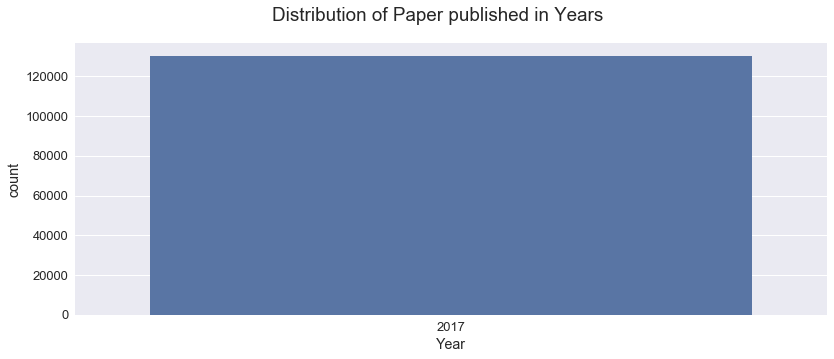

In [64]:
# paper publication throughout the period
plt.figure(figsize=(12,5))
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Year", data=df)
plt.suptitle("Distribution of Paper published in Years")

Text(0.5,0.98,'Number of paper published in each month')

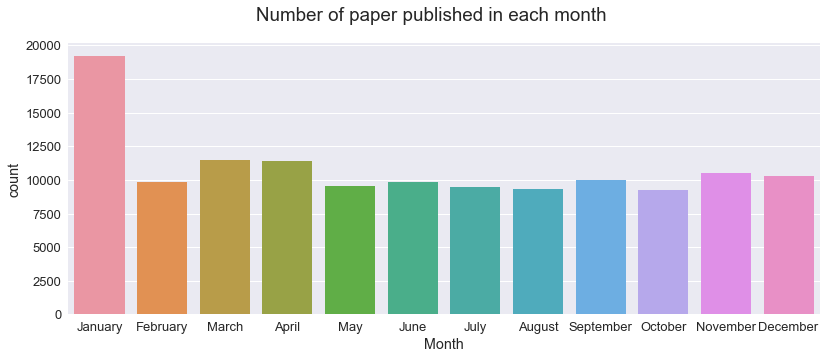

In [56]:
# paper publication around a year
plt.figure(figsize=(12,5))
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Month", data=df)
ax.set_xticklabels(["January","February","March", "April", "May", "June", "July", "August", "September", "October","November", "December"])
plt.suptitle("Number of paper published in each month")

In [86]:
max(df.Number_Of_authors)

500

In [128]:
df.sort_values(by=["Number_Of_authors"], ascending=False).head()

,Unnamed: 0,Authors,Conference,Citation_count,Date,Expected_count,Domain,Id,Journal,References,Title,Venue,Words,Year,Popularity,Month,Publication_Rank,Publication Type,Number_Of_authors
24093,99059,"[{'AuId': 1977639945, 'S': 1, 'AuN': 'r aaij'}...",NaN,0,2017-01-01,0,"[{'FId': 20252601, 'FN': 's wave'}, {'FId': 53...",2781475630,"{'JN': 'jhep', 'JId': 187585107}",NaN,erratum to measurements of the s wave fraction...,Journal of High Energy Physics,"['0', '047', '11', '2016', '892', 'b', 'branch...",2017,-20.010,1,1.227,1,500
26143,110373,"[{'S': 1, 'AuId': 1977639945, 'AfN': 'cern', '...",NaN,0,2017-09-14,0,"[{'FId': 40760194, 'FN': 'branching'}, {'FId':...",2884634884,"{'JN': 'eur phys j', 'JId': 94052278}",NaN,study of charmonium production in hadron decay...,European Physical Journal C,"['0_', 'b', 'bs0', 'charmonium', 'decay', 'dec...",2017,-20.061,9,2.022,1,500
14670,46214,"[{'S': 1, 'AuId': 2639893087, 'AfN': 'yerevan ...",NaN,15,2017-12-01,15,"[{'FId': 207206121, 'FN': 'top quark'}, {'FId'...",2622010322,"{'JN': 'eur phys j', 'JId': 94052278}","[2128158076, 2151512268, 2100507804, 216309795...",search for dark matter produced in association...,European Physical Journal C,"['13', 'association', 'collisions', 'dark', 'f...",2017,-19.731,12,2.022,1,500
78670,518018,"[{'AuId': 1977639945, 'S': 1, 'AuN': 'r aaij'}...",NaN,0,2017-01-01,0,"[{'FId': 107165499, 'FN': 'rapidity'}, {'FId':...",2750496365,"{'JN': 'jhep', 'JId': 187585107}","[2258584306, 2109896109, 2163097950, 211099917...",study of b bar b correlations in high energy p...,Journal of High Energy Physics,"['b', 'bar', 'collisions', 'correlations', 'en...",2017,-20.851,1,1.227,1,500
2297,6756,"[{'AuId': 1977639945, 'S': 1, 'AuN': 'r aaij'}...",NaN,102,2017-05-16,102,"[{'FId': 151987854, 'FN': 'invariant mass'}, {...",2615822634,"{'JN': 'jhep', 'JId': 187585107}","[2258584306, 2128881154, 2109896109, 216309795...",test of lepton universality with b 0 rightarro...,Journal of High Energy Physics,"['0', 'b', 'decays', 'ell', 'k', 'lepton', 'ri...",2017,-19.075,5,1.227,1,500


Text(0.5,0.98,'Number of authors for given paper')

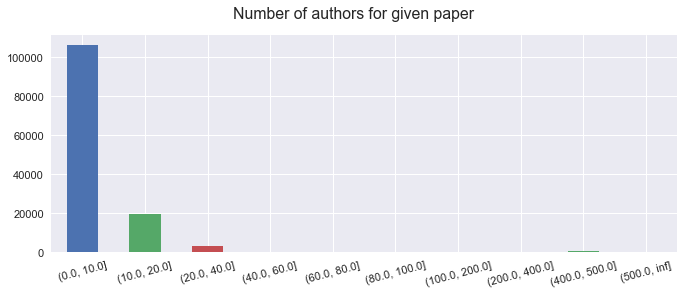

In [216]:
# Number of authors for the paper, Group data according to number of authors
bins = [0, 10, 20, 40, 60, 80, 100, 200, 400, 500, np.inf]
# author_groups = pd.cut(df["Number_Of_authors"], bins)
# df["author_groups"] = author_groups
plt.figure(figsize=(10,4))
sns.set(style="darkgrid",font_scale=1.1)
sss = pd.cut(df['Number_Of_authors'], bins=bins)
ax = sss.value_counts(sort=False).plot.bar(rot=15)
for index, row in sss.iterrows():
    g.text(row.name,row.tip, row.total_bill,2, color='black', ha="center")
# sns.distplot(sss)

plt.suptitle("Number of authors for given paper")

In [217]:
sss.value_counts()

(0.0, 10.0]       106127
(10.0, 20.0]       19464
(20.0, 40.0]        3182
(400.0, 500.0]       548
(40.0, 60.0]         422
(100.0, 200.0]       140
(60.0, 80.0]         133
(80.0, 100.0]        111
(200.0, 400.0]        77
(500.0, inf]           0
Name: Number_Of_authors, dtype: int64

In [127]:
import json
import ast
# obj = json.loads("[{'AuId': 2168721218, 'S': 1, 'AuN': 'emelia j benjamin'},]")
obj = ast.literal_eval(df["Authors"][24093])
print(len(obj))
print(json.dumps(obj[0], indent=2))
universities = { _obj["AfN"] for _obj in obj if "AfN" in _obj}
print(universities)

500
{
  "AuId": 1977639945,
  "S": 1,
  "AuN": "r aaij"
}
set()


In [ ]:
df[]

In [120]:
df["Authors"][0]

"[{'AuId': 2168721218, 'S': 1, 'AuN': 'emelia j benjamin'}, {'AuId': 2005352543, 'S': 2, 'AuN': 'michael j blaha'}, {'AuId': 104634994, 'S': 3, 'AuN': 'stephanie e chiuve'}, {'AuId': 2046859330, 'S': 4, 'AuN': 'mary cushman'}, {'AuId': 2277451764, 'S': 5, 'AuN': 'sandeep r das'}, {'AuId': 1975017443, 'S': 6, 'AuN': 'rajat deo'}, {'AuId': 1959621794, 'S': 7, 'AuN': 'sarah d de ferranti'}, {'AuId': 2101491348, 'S': 8, 'AuN': 'james s floyd'}, {'AuId': 108138892, 'S': 9, 'AuN': 'myriam fornage'}, {'AuId': 2127140094, 'S': 10, 'AuN': 'cathleen gillespie'}, {'AuId': 1772048951, 'S': 11, 'AuN': 'carmen r isasi'}, {'AuId': 2166150345, 'S': 12, 'AuN': 'monik c jimenez'}, {'AuId': 2189981646, 'S': 13, 'AuN': 'lori c jordan'}, {'AuId': 2141707827, 'S': 14, 'AuN': 'suzanne e judd'}, {'AuId': 2894344593, 'S': 15, 'AuN': 'daniel t lackland'}, {'AuId': 2168694049, 'S': 16, 'AuN': 'judith h lichtman'}, {'S': 17, 'AuId': 304513337, 'AfN': 'university of michigan', 'AfId': 27837315, 'AuN': 'lynda d lis

In [25]:
outlink_map = {}
inlink_map = {}
df_new = df[df["References"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References"]
    ref_list = list(map(int,ref.strip("[]'").split(",")))
    outlink_map[row["Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Id"])
        inlink_map[ref] = listi

In [ ]:
def calculate_page_rank():
    count = 0
    page_year = {row["Id"]:row["Year"] for _t, row in df.iterrows()}
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink_map.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    page_rank = {}
    updated_page_rank = {}
    for index in df["Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                #ns = 0.15 + (0.85 * ns)
                ns = 0.15 + float(0.85) * (ns/avg_year_citation_count[page_year[key]])
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        max_score = max(page_rank.values())
        print(f"max score is {max_score}")
        page_rank = { index:score/max_score for index, score in page_rank.items()}
        return page_rank

In [ ]:
page_rank = calculate_page_rank()
print(max(page_rank.values()))
print(sum(page_rank.values()))

In [ ]:
df["page_rank"] = 0
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)
df["page_rank"][0:10]

In [ ]:
df.to_csv("ranked_processed_data.csv")

In [ ]:
# from sklearn.utils.extmath import softmax
# df["page_rank"]  = softmax(df["page_rank"].values())

In [ ]:
# df.to_csv("ranked_softmax_processed_data.csv")